<a href="https://colab.research.google.com/github/Gutzu-Encoder/Domain-Adversarial-Training-between-NIH-CXR-and-Chexpert-small.-/blob/main/Domain_adversarial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub

# Download latest version
path1 = kagglehub.dataset_download("ashery/chexpert")

print("Path to dataset files:", path1)

Using Colab cache for faster access to the 'chexpert' dataset.
Path to dataset files: /kaggle/input/chexpert


In [3]:
import kagglehub

# Download latest version
path2 = kagglehub.dataset_download("nih-chest-xrays/data")

print("Path to dataset files:", path2)

100%|██████████| 42.0G/42.0G [31:51<00:00, 23.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3


In [4]:
import os
os.listdir(path1)

['valid.csv', 'valid', 'train.csv', 'train']

we'll use only the disease that both nih CXR and chexpert-small dataset have in common.

the data already split train and validation set for us

lets check for data leakage

In [105]:
import pandas as pd
from PIL import Image
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
train_chexpert_csv = os.path.join(path1, "train.csv")
validation_chexpert_csv = os.path.join(path1, "valid.csv")
df_train = pd.read_csv(train_chexpert_csv)
df_valid = pd.read_csv(validation_chexpert_csv)

# Remove redundant prefix from CheXpert paths
df_train['Path'] = df_train['Path'].str.replace('CheXpert-v1.0-small/', '', regex=False)
df_valid['Path'] = df_valid['Path'].str.replace('CheXpert-v1.0-small/', '', regex=False)

In [106]:
df_train.head(10)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,train/patient00001/study1/view1_frontal.jpg,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,train/patient00002/study2/view1_frontal.jpg,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,train/patient00002/study1/view1_frontal.jpg,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,train/patient00002/study1/view2_lateral.jpg,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,train/patient00003/study1/view1_frontal.jpg,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
5,train/patient00004/study1/view1_frontal.jpg,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
6,train/patient00004/study1/view2_lateral.jpg,Female,20,Lateral,NaN,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
7,train/patient00005/study1/view1_frontal.jpg,Male,33,Frontal,PA,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0
8,train/patient00005/study1/view2_lateral.jpg,Male,33,Lateral,NaN,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0
9,train/patient00005/study2/view1_frontal.jpg,Male,33,Frontal,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [107]:
df_valid.head(10)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,valid/patient64541/study1/view1_frontal.jpg,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,valid/patient64542/study1/view1_frontal.jpg,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,valid/patient64542/study1/view2_lateral.jpg,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,valid/patient64543/study1/view1_frontal.jpg,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,valid/patient64544/study1/view1_frontal.jpg,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,valid/patient64545/study1/view1_frontal.jpg,Female,55,Frontal,AP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,valid/patient64546/study1/view1_frontal.jpg,Male,56,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7,valid/patient64547/study1/view1_frontal.jpg,Male,59,Frontal,PA,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,valid/patient64547/study1/view2_frontal.jpg,Male,59,Frontal,PA,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,valid/patient64547/study1/view3_lateral.jpg,Male,59,Lateral,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


the data have 3 classes being 0 for no report, 1 for report shown, -1 for uncertrain and NaN for no discussion

we can see many NaN and there's no specific column for Patient ID which will post a problem for checking data leakage problem(-> leads to Spurious correlations)

we'll create a scecific column for patient id then check it


In [120]:
df_train["patient_id"] = df_train["Path"].str.split("/").str[2]
df_valid["patient_id"] = df_valid["Path"].str.split("/").str[2]

train_ids = set(df_train["patient_id"].unique())
valid_ids = set(df_valid["patient_id"].unique())
overlap = train_ids & valid_ids

print( len(overlap))

1


In [122]:
overlap_ids = list(overlap)
print("Overlapping patient_ids:", overlap_ids)

df_train = df_train[~df_train["patient_id"].isin(overlap_ids)].reset_index(drop=True)
df_valid = df_valid[~df_valid["patient_id"].isin(overlap_ids)].reset_index(drop=True)

train_ids = set(df_train["patient_id"].unique())
valid_ids = set(df_valid["patient_id"].unique())
overlap = train_ids & valid_ids
print("Overlap after drop:", len(overlap))


Overlapping patient_ids: ['study1']
Overlap after drop: 0


This ensure that we have no data leakage problem for chexpert small dataset

lets check some missing values

In [123]:
meta_cols = ["Path", "Sex", "Age", "Frontal/Lateral", "AP/PA"]
print(df_train[meta_cols].isna().sum())
print(df_valid[meta_cols].isna().sum())


Path                   0
Sex                    0
Age                    0
Frontal/Lateral        0
AP/PA              16129
dtype: int64
Path               0
Sex                0
Age                0
Frontal/Lateral    0
AP/PA              0
dtype: int64


In [124]:

label_cols = [c for c in df_train.columns if c not in meta_cols]

print("Number of label columns:", len(label_cols))

missing_per_label_train = df_train[label_cols].isna().sum().sort_values(ascending=False)
missing_per_label_valid = df_valid[label_cols].isna().sum().sort_values(ascending=False)

print("\nTop label missing (train):")
print(missing_per_label_train.head(20))

print("\nTop label missing (valid):")
print(missing_per_label_valid.head(20))


Number of label columns: 15

Top label missing (train):
Pleural Other                 137555
Fracture                      135879
Lung Lesion                   135273
No Finding                    132938
Pneumonia                     125323
Enlarged Cardiomediastinum    118994
Cardiomegaly                  113153
Consolidation                 101241
Atelectasis                    96666
Pneumothorax                   93726
Edema                          83323
Lung Opacity                   60544
Pleural Effusion               52809
Support Devices                49702
patient_id                         0
dtype: int64

Top label missing (valid):
No Finding                    0
Enlarged Cardiomediastinum    0
Cardiomegaly                  0
Lung Opacity                  0
Lung Lesion                   0
Edema                         0
Consolidation                 0
Pneumonia                     0
Atelectasis                   0
Pneumothorax                  0
Pleural Effusion            

lets check all the label

In [125]:
label_cols = [c for c in df_train.columns if c not in meta_cols]
print("Label columns:", label_cols)


Label columns: ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices', 'patient_id']


Lets check for class distribution to see if there're class imbalance

In [126]:
for col in label_cols:
    print(col)
    print("-----------"*10)
    print(df_train[col].value_counts(dropna=False))


No Finding
--------------------------------------------------------------------------------------------------------------
No Finding
NaN    132938
1.0      8273
Name: count, dtype: int64
Enlarged Cardiomediastinum
--------------------------------------------------------------------------------------------------------------
Enlarged Cardiomediastinum
 NaN    118994
-1.0      9083
 0.0      6890
 1.0      6244
Name: count, dtype: int64
Cardiomegaly
--------------------------------------------------------------------------------------------------------------
Cardiomegaly
 NaN    113153
 1.0     18788
-1.0      4836
 0.0      4434
Name: count, dtype: int64
Lung Opacity
--------------------------------------------------------------------------------------------------------------
Lung Opacity
 1.0    74239
 NaN    60544
-1.0     3364
 0.0     3064
Name: count, dtype: int64
Lung Lesion
------------------------------------------------------------------------------------------------------------

Now the thing is that this Chexpert-small data is the target data for our Domain adversarial training which the source data(NIH CXR dataset) only include 2 label classes being 0/1.

In this dataset, we'll convert all label except 1 to be 0


In [127]:
df_train[label_cols]

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,patient_id
0,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,study2
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,study2
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,study2
3,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,NaN,0.0,1.0,study2
4,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,1.0,study2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141206,NaN,NaN,NaN,1.0,NaN,-1.0,NaN,-1.0,1.0,NaN,NaN,NaN,NaN,NaN,study2
141207,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,study2
141208,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,study2
141209,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,study2


In [128]:

numerical_label_cols = [col for col in label_cols if col != "patient_id"]
labels_train_raw = df_train[numerical_label_cols].copy()
labels_train_binary = labels_train_raw.fillna(0).replace(-1, 0)
labels_train_binary = labels_train_binary.astype("float32")
print(labels_train_binary.head())

   No Finding  Enlarged Cardiomediastinum  Cardiomegaly  Lung Opacity  \
0         0.0                         0.0           0.0           1.0   
1         0.0                         0.0           0.0           0.0   
2         0.0                         0.0           0.0           0.0   
3         0.0                         1.0           0.0           1.0   
4         0.0                         0.0           0.0           1.0   

   Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  Pneumothorax  \
0          0.0    0.0            0.0        0.0          0.0           0.0   
1          0.0    0.0            0.0        0.0          0.0           1.0   
2          0.0    0.0            0.0        0.0          0.0           1.0   
3          0.0    0.0            0.0        0.0          1.0           0.0   
4          0.0    0.0            0.0        0.0          0.0           0.0   

   Pleural Effusion  Pleural Other  Fracture  Support Devices  
0               0.0         

In [129]:
numerical_label_cols = [col for col in label_cols if col != "patient_id"]
labels_valid_raw = df_valid[numerical_label_cols].copy()
labels_valid_binary = labels_valid_raw.fillna(0).replace(-1, 0)
labels_valid_binary = labels_valid_binary.astype("float32")
print(labels_valid_binary.head())

Empty DataFrame
Columns: [No Finding, Enlarged Cardiomediastinum, Cardiomegaly, Lung Opacity, Lung Lesion, Edema, Consolidation, Pneumonia, Atelectasis, Pneumothorax, Pleural Effusion, Pleural Other, Fracture, Support Devices]
Index: []


recheck again

In [130]:
for col in label_cols:
    print(col)
    print("-----------"*10)
    print(labels_valid_binary.value_counts(dropna=False))

No Finding
--------------------------------------------------------------------------------------------------------------
Series([], Name: count, dtype: int64)
Enlarged Cardiomediastinum
--------------------------------------------------------------------------------------------------------------
Series([], Name: count, dtype: int64)
Cardiomegaly
--------------------------------------------------------------------------------------------------------------
Series([], Name: count, dtype: int64)
Lung Opacity
--------------------------------------------------------------------------------------------------------------
Series([], Name: count, dtype: int64)
Lung Lesion
--------------------------------------------------------------------------------------------------------------
Series([], Name: count, dtype: int64)
Edema
--------------------------------------------------------------------------------------------------------------
Series([], Name: count, dtype: int64)
Consolidation
----------

next ofcourse, the class will be imbalance so will tackle this

In [131]:
import pandas as pd

num_samples = len(labels_train_binary)
rows = []

for col in numerical_label_cols:
    pos = int(labels_train_binary[col].sum())          # number of 1s
    neg = int(num_samples - pos)                       # number of 0s
    pos_ratio = pos / num_samples
    rows.append({
        "label": col,
        "pos": pos,
        "neg": neg,
        "pos_ratio": pos_ratio
    })

class_stats = pd.DataFrame(rows).set_index("label").sort_values("pos_ratio")
print(class_stats)

                              pos     neg  pos_ratio
label                                               
Pleural Other                2085  139126   0.014765
Pneumonia                    3225  137986   0.022838
Fracture                     4703  136508   0.033305
Lung Lesion                  4952  136259   0.035068
Enlarged Cardiomediastinum   6244  134967   0.044218
No Finding                   8273  132938   0.058586
Consolidation               10675  130536   0.075596
Pneumothorax                15393  125818   0.109007
Cardiomegaly                18788  122423   0.133049
Atelectasis                 22095  119116   0.156468
Edema                       39202  102009   0.277613
Pleural Effusion            66788   74423   0.472966
Lung Opacity                74239   66972   0.525731
Support Devices             86028   55183   0.609216


but because not all label here is common with the nih dataset's label, so we'll be tackle with this later on.

we'll be using only PatientID and the images in our model because the tabular data holds almost no semantic values.

In [132]:
df_train_chexpert = pd.concat(
    [
        df_train[["Path", "patient_id"]].reset_index(drop=True),
        labels_train_binary.reset_index(drop=True),
    ],
    axis=1,
)

print(df_train_chexpert.head())

                                          Path patient_id  No Finding  \
0  train/patient00002/study2/view1_frontal.jpg     study2         0.0   
1  train/patient00005/study2/view1_frontal.jpg     study2         0.0   
2  train/patient00005/study2/view2_frontal.jpg     study2         0.0   
3  train/patient00007/study2/view1_frontal.jpg     study2         0.0   
4  train/patient00008/study2/view1_frontal.jpg     study2         0.0   

   Enlarged Cardiomediastinum  Cardiomegaly  Lung Opacity  Lung Lesion  Edema  \
0                         0.0           0.0           1.0          0.0    0.0   
1                         0.0           0.0           0.0          0.0    0.0   
2                         0.0           0.0           0.0          0.0    0.0   
3                         1.0           0.0           1.0          0.0    0.0   
4                         0.0           0.0           1.0          0.0    0.0   

   Consolidation  Pneumonia  Atelectasis  Pneumothorax  Pleural Effusion  

In [133]:
df_valid_chexpert = pd.concat(
    [
        df_valid[["Path", "patient_id"]].reset_index(drop=True),
        labels_valid_binary.reset_index(drop=True),
    ],
    axis=1,
)

print(df_valid_chexpert.head())

Empty DataFrame
Columns: [Path, patient_id, No Finding, Enlarged Cardiomediastinum, Cardiomegaly, Lung Opacity, Lung Lesion, Edema, Consolidation, Pneumonia, Atelectasis, Pneumothorax, Pleural Effusion, Pleural Other, Fracture, Support Devices]
Index: []


Alright let us move on to the chexpert dataset -> clearing dataset => check for common label => drop the label that's not common => tackle class imbalance problem

In [134]:
nih_csv = os.path.join(path2, "Data_Entry_2017.csv")
df_nih = pd.read_csv(nih_csv)
df_nih.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [135]:
df_nih.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [136]:
df_nih.isna().sum()


,0
Image Index,0
Finding Labels,0
Follow-up #,0
Patient ID,0
Patient Age,0
Patient Gender,0
View Position,0
OriginalImage[Width,0
Height],0
OriginalImagePixelSpacing[x,0


In [137]:
all_labels = set()
for s in df_nih['Finding Labels']:
    for lab in s.split("|"):
        all_labels.add(lab)
sorted(all_labels)

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [138]:
diseases = [
    'Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion',
    'Emphysema','Fibrosis','Hernia','Infiltration','Mass','Nodule',
    'Pleural_Thickening','Pneumonia','Pneumothorax', 'No Finding'
]


changes the name of column to match chexpert

In [139]:
df_nih["patient_id"] = df_nih["Patient ID"].astype(str)

will tackle patient id leakage problem

In [140]:
from sklearn.model_selection import train_test_split

unique_ids = df_nih["patient_id"].unique()
print("Total unique patients:", len(unique_ids))

train_pids, temp_pids = train_test_split(
    unique_ids,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)
val_pids, test_pids = train_test_split(
    temp_pids,
    test_size=0.50,
    random_state=42,
    shuffle=True,
)

print("train patients:", len(train_pids))
print("val patients:", len(val_pids))
print("test patients:", len(test_pids))


Total unique patients: 30805
train patients: 24644
val patients: 3080
test patients: 3081


In [141]:
df_nih_train = df_nih[df_nih["patient_id"].isin(train_pids)].copy()
df_nih_val   = df_nih[df_nih["patient_id"].isin(val_pids)].copy()
df_nih_test  = df_nih[df_nih["patient_id"].isin(test_pids)].copy()

print(len(df_nih_train))
print(len(df_nih_val))
print(len(df_nih_test))


89826
10930
11364


In [142]:
train_ids = set(df_nih_train["patient_id"])
val_ids   = set(df_nih_val["patient_id"])
test_ids  = set(df_nih_test["patient_id"])

print("train overlap val:", len(train_ids & val_ids))
print("train overlap test:", len(train_ids & test_ids))
print("val overlap test:", len(val_ids & test_ids))


train overlap val: 0
train overlap test: 0
val overlap test: 0


No overlap here so we can ensure that the data leakage problem does not occurs.

some finding label are written as Cardiomegaly|Emphysema meaning multiple labels in form of new parameter => we'll seperate them into one hot encoding for each diseases

In [143]:
for d in diseases:
    df_nih_train[d] = df_nih_train["Finding Labels"].str.contains(d).astype(int)
    df_nih_test[d]  = df_nih_test["Finding Labels"].str.contains(d).astype(int)
    df_nih_val[d] = df_nih_val["Finding Labels"].str.contains(d).astype(int)

In [144]:
df_nih_train.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,No Finding
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,1
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0


In [57]:
df_nih_train[diseases].head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,No Finding
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [58]:
df_nih_train

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,No Finding
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,1
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112114,00030801_000.png,No Finding,0,30801,39,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,1
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,1,0,0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,1
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,1


One thing is that the df doesn't contain the path to our image so lets stitched it together + also ditch the tabular data(since they held almost no semantic contribution)

In [145]:
import os
image_path_map = {}
for root, _, files in os.walk(path2):
    for file in files:
        if file.endswith('.png'):
            image_path_map[file] = os.path.join(root, file)

# Update the 'Path' column in NIH DataFrames to use absolute paths
df_nih_train["Path"] = df_nih_train["Image Index"].map(image_path_map)
df_nih_val["Path"]   = df_nih_val["Image Index"].map(image_path_map)
df_nih_test["Path"]  = df_nih_test["Image Index"].map(image_path_map)


In [146]:
nih_label_cols = diseases

df_nih_train_clean = df_nih_train[["Path", "patient_id"] + diseases].copy()
df_nih_val_clean   = df_nih_val[["Path", "patient_id"] + diseases].copy()
df_nih_test_clean  = df_nih_test[["Path", "patient_id"] + diseases].copy()

df_nih_train_clean.head()



,Path,patient_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,No Finding
0,/root/.cache/kagglehub/datasets/nih-chest-xray...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,/root/.cache/kagglehub/datasets/nih-chest-xray...,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,/root/.cache/kagglehub/datasets/nih-chest-xray...,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,/root/.cache/kagglehub/datasets/nih-chest-xray...,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,/root/.cache/kagglehub/datasets/nih-chest-xray...,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


Now we'll only include the common label between the chexpert small and nih.

Now this raises a question, what if a patient have disease A+B but we remove label B, would that be a misdiagnosis? And the answer is yes, it'll be a misdiagnosis.But in DANN, it's absolutely necesasry to make the label common so we'll be noting that the clinical disease of that patient could be more than what our model sees.



In [147]:
meta_cols = ["Sex", "Age", "Frontal/Lateral", "AP/PA"]
chex_label_cols = [c for c in df_train.columns
                   if c not in (["Path", "patient_id"] + meta_cols)]

chex_set = set(chex_label_cols)
nih_set  = set(nih_label_cols)

common_labels = sorted(list(chex_set & nih_set))
chex_only     = sorted(list(chex_set - nih_set))
nih_only      = sorted(list(nih_set - chex_set))

print("Common labels (exact name match):", common_labels)
print("Only in CheXpert:", chex_only)
print("Only in NIH:", nih_only)

Common labels (exact name match): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'No Finding', 'Pneumonia', 'Pneumothorax']
Only in CheXpert: ['Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity', 'Pleural Effusion', 'Pleural Other', 'Support Devices']
Only in NIH: ['Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening']


In [148]:
df_chex_train_aligned = df_train_chexpert[["Path", "patient_id"] + common_labels].copy()
df_chex_valid_aligned = df_valid_chexpert[["Path", "patient_id"] + common_labels].copy()

print(df_chex_train_aligned.head())


                                          Path patient_id  Atelectasis  \
0  train/patient00002/study2/view1_frontal.jpg     study2          0.0   
1  train/patient00005/study2/view1_frontal.jpg     study2          0.0   
2  train/patient00005/study2/view2_frontal.jpg     study2          0.0   
3  train/patient00007/study2/view1_frontal.jpg     study2          1.0   
4  train/patient00008/study2/view1_frontal.jpg     study2          0.0   

   Cardiomegaly  Consolidation  Edema  No Finding  Pneumonia  Pneumothorax  
0           0.0            0.0    0.0         0.0        0.0           0.0  
1           0.0            0.0    0.0         0.0        0.0           1.0  
2           0.0            0.0    0.0         0.0        0.0           1.0  
3           0.0            0.0    0.0         0.0        0.0           0.0  
4           0.0            0.0    0.0         0.0        0.0           0.0  


In [149]:
df_nih_train_aligned = df_nih_train[["Path", "patient_id"] + common_labels].copy()
df_nih_val_aligned   = df_nih_val[["Path", "patient_id"] + common_labels].copy()
df_nih_test_aligned  = df_nih_test[["Path", "patient_id"] + common_labels].copy()

print(df_nih_train_aligned.head())


                                                Path patient_id  Atelectasis  \
0  /root/.cache/kagglehub/datasets/nih-chest-xray...          1            0   
1  /root/.cache/kagglehub/datasets/nih-chest-xray...          1            0   
2  /root/.cache/kagglehub/datasets/nih-chest-xray...          1            0   
3  /root/.cache/kagglehub/datasets/nih-chest-xray...          2            0   
4  /root/.cache/kagglehub/datasets/nih-chest-xray...          3            0   

   Cardiomegaly  Consolidation  Edema  No Finding  Pneumonia  Pneumothorax  
0             1              0      0           0          0             0  
1             1              0      0           0          0             0  
2             1              0      0           0          0             0  
3             0              0      0           1          0             0  
4             0              0      0           0          0             0  


well there's one thng is that the chexpert contain pleural effusion while the nih contain effusion.
since the context is CXR, we'll assume that the semantic meaning is the same

In [150]:
for df_split in (df_nih_train, df_nih_val, df_nih_test):
    df_split.rename(columns={"Effusion": "Pleural Effusion"}, inplace=True)

diseases = ["Pleural Effusion" if d == "Effusion" else d for d in diseases]

chexpert_diseases = [c for c in df_train_chexpert.columns
                     if c not in ["Path", "patient_id"]]

shared_diseases = sorted(set(chexpert_diseases) & set(diseases))
print(shared_diseases)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'No Finding', 'Pleural Effusion', 'Pneumonia', 'Pneumothorax']


In [151]:
df_chex_train_aligned = df_train_chexpert[["Path", "patient_id"] + shared_diseases].copy()
df_chex_valid_aligned = df_valid_chexpert[["Path", "patient_id"] + shared_diseases].copy()

df_nih_train_aligned = df_nih_train[["Path", "patient_id"] + shared_diseases].copy()
df_nih_val_aligned   = df_nih_val[["Path", "patient_id"] + shared_diseases].copy()
df_nih_test_aligned  = df_nih_test[["Path", "patient_id"] + shared_diseases].copy()

print(df_nih_train_aligned.head())

                                                Path patient_id  Atelectasis  \
0  /root/.cache/kagglehub/datasets/nih-chest-xray...          1            0   
1  /root/.cache/kagglehub/datasets/nih-chest-xray...          1            0   
2  /root/.cache/kagglehub/datasets/nih-chest-xray...          1            0   
3  /root/.cache/kagglehub/datasets/nih-chest-xray...          2            0   
4  /root/.cache/kagglehub/datasets/nih-chest-xray...          3            0   

   Cardiomegaly  Consolidation  Edema  No Finding  Pleural Effusion  \
0             1              0      0           0                 0   
1             1              0      0           0                 0   
2             1              0      0           0                 1   
3             0              0      0           1                 0   
4             0              0      0           0                 0   

   Pneumonia  Pneumothorax  
0          0             0  
1          0             0  
2    

After all of the trouble, we finally get the shared labels without data problem. except let us check if there's class imbalance

In [152]:
nih_total = len(df_nih_train_aligned)
nih_pos = df_nih_train_aligned[shared_diseases].sum(axis=0)
nih_neg = nih_total - nih_pos

nih_stats = pd.DataFrame({
    "pos": nih_pos.astype(int),
    "neg": nih_neg.astype(int),
    "pos_ratio": (nih_pos / nih_total)
}).sort_values("pos_ratio")

print("\nNIH train disease stats:")
print(nih_stats)


NIH train disease stats:
                    pos    neg  pos_ratio
Pneumonia          1137  88689   0.012658
Edema              1849  87977   0.020584
Cardiomegaly       2158  87668   0.024024
Consolidation      3716  86110   0.041369
Pneumothorax       4282  85544   0.047670
Atelectasis        9352  80474   0.104112
Pleural Effusion  10764  79062   0.119832
No Finding        48373  41453   0.538519


In [153]:
chex_total = len(df_chex_train_aligned)
chex_pos = df_chex_train_aligned[shared_diseases].sum(axis=0)
chex_neg = chex_total - chex_pos

chex_stats = pd.DataFrame({
    "pos": chex_pos.astype(int),
    "neg": chex_neg.astype(int),
    "pos_ratio": (chex_pos / chex_total)
}).sort_values("pos_ratio")

print("CheXpert train disease stats:")
print(chex_stats)



CheXpert train disease stats:
                    pos     neg  pos_ratio
Pneumonia          3225  137986   0.022838
No Finding         8273  132938   0.058586
Consolidation     10675  130536   0.075596
Pneumothorax      15393  125818   0.109007
Cardiomegaly      18788  122423   0.133049
Atelectasis       22095  119116   0.156468
Edema             39202  102009   0.277613
Pleural Effusion  66788   74423   0.472966


well we could see some class imbalance and unequal here between the 2 datasets, which will causes impact upon training. But in DANN => the target data(small Chexpert) don't use labels so we'll be handling class imbalance only in NIH

In [154]:
N = len(df_nih_train_aligned)

source_pos = df_nih_train_aligned[shared_diseases].sum(axis=0)
source_neg = N - source_pos

# avoid divide-by-zero in case something is insane
source_pos_safe = source_pos.replace(0, 1)

# pos_weight = neg / pos
source_pos_weight_series = source_neg / source_pos_safe
print("NIH pos_weight per disease:")
print(source_pos_weight_series)


NIH pos_weight per disease:
Atelectasis          8.605004
Cardiomegaly        40.624652
Consolidation       23.172766
Edema               47.580855
No Finding           0.856945
Pleural Effusion     7.345039
Pneumonia           78.002639
Pneumothorax        19.977581
dtype: float64


In [155]:
import torch
pos_weight = torch.tensor(
    [source_pos_weight_series[d] for d in shared_diseases],
    dtype=torch.float32
)
print("pos_weight tensor:", pos_weight)


pos_weight tensor: tensor([ 8.6050, 40.6247, 23.1728, 47.5809,  0.8569,  7.3450, 78.0026, 19.9776])


In [156]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pos_weight = pos_weight.to(device)


We cleared all the dataset, next will move on to our DANN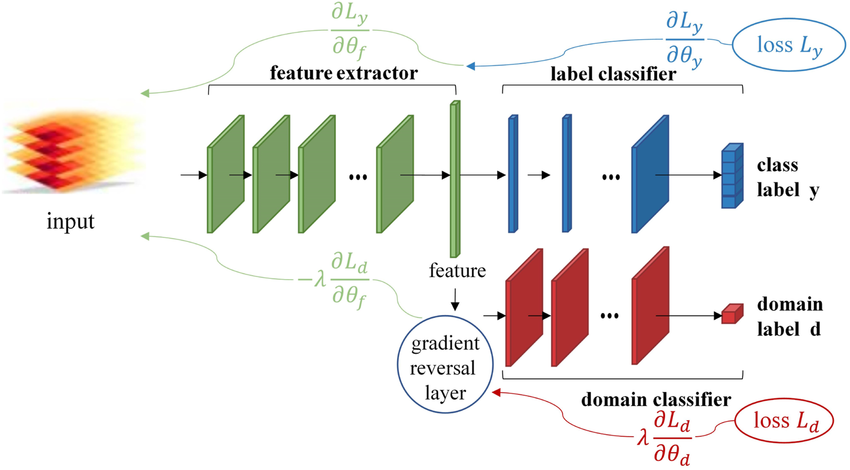

for domain's label to enter domain classifier
will use 0 = NIH and 1 = Chexpert

In [157]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

cxr_transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [158]:
class CXRDannDataset(Dataset):
    def __init__(self, df, root_dir, shared_diseases, transform=None, domain_id=0):

        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.shared_diseases = shared_diseases
        self.transform = transform
        self.domain_id = domain_id

    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.root_dir, row["Path"])
        image = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)

        labels = torch.tensor(
            row[self.shared_diseases].astype(np.float32).values,
            dtype=torch.float32
        )
        patient_id = row["patient_id"]

        domain = torch.tensor(self.domain_id, dtype=torch.long)
        return image, labels, patient_id, domain

In [159]:
nih_train_dataset = CXRDannDataset(
    df=df_nih_train_aligned,
    root_dir='', # Set to empty as 'Path' column will now contain absolute paths
    shared_diseases=shared_diseases,
    transform=cxr_transform,
    domain_id=0,
)

nih_val_dataset = CXRDannDataset(
    df=df_nih_val_aligned,
    root_dir='', # Set to empty as 'Path' column will now contain absolute paths
    shared_diseases=shared_diseases,
    transform=cxr_transform,
    domain_id=0,
)

chex_train_dataset = CXRDannDataset(
    df=df_chex_train_aligned,
    root_dir=path1,
    shared_diseases=shared_diseases,
    transform=cxr_transform,
    domain_id=1,
)

chex_val_dataset = CXRDannDataset(
    df=df_chex_valid_aligned,
    root_dir=path1,
    shared_diseases=shared_diseases,
    transform=cxr_transform,
    domain_id=1,
)

In [160]:
batch_size = 16

nih_train_loader = DataLoader(
    nih_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

chex_train_loader = DataLoader(
    chex_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
images, labels, pids, domains = next(iter(nih_train_loader))
print("NIH batch:", images.shape, labels.shape, domains.unique(), pids[0])

images_t, labels_t, pids_t, domains_t = next(iter(chex_train_loader))
print("CheX batch:", images_t.shape, labels_t.shape, domains_t.unique(), pids_t[0])


NIH batch: torch.Size([16, 3, 320, 320]) torch.Size([16, 8]) tensor([0]) 4278
CheX batch: torch.Size([16, 3, 320, 320]) torch.Size([16, 8]) tensor([1]) study12


In [161]:
import torch.nn as nn
from torch.autograd import Function
class GradReverse(Function):
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    def backward(ctx, grad_output):
        return -ctx.alpha * grad_output, None
def grad_reverse(x, alpha):
    return GradReverse.apply(x, alpha)

In [163]:
import torch.nn.functional as F
from torchvision import models
class DANN_DenseNet121(nn.Module):
    def __init__(self, num_diseases):
        super().__init__()
        backbone = models.densenet121(pretrained=True)
        self.features = backbone.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        feat_dim = backbone.classifier.in_features

        self.classifier = nn.Linear(feat_dim, num_diseases)

        self.domain_classifier = nn.Sequential(
            nn.Linear(feat_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2),     # 0 = NIH, 1 = CheXpert
        )

    def forward(self, x, alpha=1.0):
        # feature extractor
        feat = self.features(x)              # [B, 1024, H', W']
        feat = F.relu(feat, inplace=True)
        feat = self.pool(feat)               # [B, 1024, 1, 1]
        feat = torch.flatten(feat, 1)        # [B, 1024]

        # disease logits (no grad reversal)
        class_logits = self.classifier(feat)

        # domain logits (with grad reversal)
        rev_feat = grad_reverse(feat, alpha)
        domain_logits = self.domain_classifier(rev_feat)

        return class_logits, domain_logits


In [164]:
num_diseases = len(shared_diseases)
model = DANN_DenseNet121(num_diseases=num_diseases).to(device)

criterion_cls = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
criterion_domain = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 238MB/s]


In [165]:
model.train()

nih_iter = iter(nih_train_loader)
chex_iter = iter(chex_train_loader)

# 1 batch from each
x_src, y_src, _, _ = next(nih_iter)   # NIH (source, has labels)
x_tgt, _, _, _    = next(chex_iter)   # CheXpert (target, ignore labels)

x_src = x_src.to(device)
y_src = y_src.to(device)
x_tgt = x_tgt.to(device)

# domain labels
d_src = torch.zeros(x_src.size(0), dtype=torch.long, device=device)  # 0 = NIH
d_tgt = torch.ones(x_tgt.size(0), dtype=torch.long, device=device)   # 1 = CheX

alpha = 1.0          # you can schedule this later
lambda_domain = 1.0  # weight for domain loss

# forward NIH
cls_logits_src, dom_logits_src = model(x_src, alpha=alpha)

# forward CheXpert (only domain head matters)
_, dom_logits_tgt = model(x_tgt, alpha=alpha)

# losses
loss_cls = criterion_cls(cls_logits_src, y_src)
loss_dom_src = criterion_domain(dom_logits_src, d_src)
loss_dom_tgt = criterion_domain(dom_logits_tgt, d_tgt)
loss_domain = loss_dom_src + loss_dom_tgt

loss_total = loss_cls + lambda_domain * loss_domain

optimizer.zero_grad()
loss_total.backward()
optimizer.step()

print(
    "loss_cls:", float(loss_cls.item()),
    "loss_domain:", float(loss_domain.item())
)


loss_cls: 1.234506607055664 loss_domain: 1.4024183750152588


In [166]:
from tqdm.auto import tqdm
import torch

num_epochs = 20
lambda_domain = 1.0

history = {
    "train_cls_loss": [],
    "train_domain_loss": [],
    "train_total_loss": [],
}

for epoch in range(num_epochs):
    model.train()
    epoch_cls = 0.0
    epoch_dom = 0.0
    epoch_total = 0.0
    steps = 0

    # we’ll iterate over both loaders together
    num_steps = min(len(nih_train_loader), len(chex_train_loader))

    pbar = tqdm(
        zip(nih_train_loader, chex_train_loader),
        total=num_steps,
        desc=f"Epoch {epoch+1}/{num_epochs}",
        leave=True,
    )

    for (x_src, y_src, _, _), (x_tgt, _, _, _) in pbar:
        x_src = x_src.to(device)
        y_src = y_src.to(device)
        x_tgt = x_tgt.to(device)

        # 0 = NIH, 1 = CheXpert
        d_src = torch.zeros(x_src.size(0), dtype=torch.long, device=device)
        d_tgt = torch.ones(x_tgt.size(0), dtype=torch.long, device=device)

        # keep it simple for now
        alpha = 1.0

        cls_logits_src, dom_logits_src = model(x_src, alpha=alpha)
        _,              dom_logits_tgt = model(x_tgt, alpha=alpha)

        loss_cls = criterion_cls(cls_logits_src, y_src)
        loss_dom_src = criterion_domain(dom_logits_src, d_src)
        loss_dom_tgt = criterion_domain(dom_logits_tgt, d_tgt)
        loss_domain = loss_dom_src + loss_dom_tgt

        loss_total = loss_cls + lambda_domain * loss_domain

        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()

        epoch_cls += loss_cls.item()
        epoch_dom += loss_domain.item()
        epoch_total += loss_total.item()
        steps += 1

        # show something a human can glance at
        pbar.set_postfix({
            "cls": f"{loss_cls.item():.2f}",
            "dom": f"{loss_domain.item():.2f}",
            "tot": f"{loss_total.item():.2f}",
        })

    # average per epoch
    avg_cls = epoch_cls / steps
    avg_dom = epoch_dom / steps
    avg_tot = epoch_total / steps

    # store history for later comparison
    history["train_cls_loss"].append(avg_cls)
    history["train_domain_loss"].append(avg_dom)
    history["train_total_loss"].append(avg_tot)

    # small “commentary” on progress
    prev_cls = history["train_cls_loss"][-2] if len(history["train_cls_loss"]) > 1 else None
    trend = ""
    if prev_cls is not None:
        if avg_cls < prev_cls:
            trend = " (better ↓)"
        elif avg_cls > prev_cls:
            trend = " (worse ↑)"
        else:
            trend = " (same)"

    print(
        f"Epoch {epoch+1}/{num_epochs} "
        f"| cls_loss: {avg_cls:.3f} "
        f"| dom_loss: {avg_dom:.3f} "
        f"| total: {avg_tot:.3f}{trend}"
    )


Epoch 1/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 1/20 | cls_loss: 0.960 | dom_loss: 1.385 | total: 2.345


Epoch 2/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 2/20 | cls_loss: 0.892 | dom_loss: 1.387 | total: 2.279 (better ↓)


Epoch 3/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 3/20 | cls_loss: 0.855 | dom_loss: 1.386 | total: 2.242 (better ↓)


Epoch 4/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 4/20 | cls_loss: 0.814 | dom_loss: 1.386 | total: 2.201 (better ↓)


Epoch 5/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 5/20 | cls_loss: 0.767 | dom_loss: 1.387 | total: 2.153 (better ↓)


Epoch 6/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 6/20 | cls_loss: 0.711 | dom_loss: 1.386 | total: 2.098 (better ↓)


Epoch 7/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 7/20 | cls_loss: 0.652 | dom_loss: 1.386 | total: 2.038 (better ↓)


Epoch 8/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 8/20 | cls_loss: 0.605 | dom_loss: 1.386 | total: 1.991 (better ↓)


Epoch 9/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 9/20 | cls_loss: 0.556 | dom_loss: 1.386 | total: 1.942 (better ↓)


Epoch 10/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 10/20 | cls_loss: 0.518 | dom_loss: 1.386 | total: 1.904 (better ↓)


Epoch 11/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 11/20 | cls_loss: 0.490 | dom_loss: 1.386 | total: 1.876 (better ↓)


Epoch 12/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 12/20 | cls_loss: 0.451 | dom_loss: 1.386 | total: 1.837 (better ↓)


Epoch 13/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 13/20 | cls_loss: 0.419 | dom_loss: 1.386 | total: 1.805 (better ↓)


Epoch 14/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 14/20 | cls_loss: 0.392 | dom_loss: 1.386 | total: 1.778 (better ↓)


Epoch 15/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 15/20 | cls_loss: 0.369 | dom_loss: 1.386 | total: 1.755 (better ↓)


Epoch 16/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 16/20 | cls_loss: 0.340 | dom_loss: 1.386 | total: 1.726 (better ↓)


Epoch 17/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 17/20 | cls_loss: 0.325 | dom_loss: 1.386 | total: 1.711 (better ↓)


Epoch 18/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 18/20 | cls_loss: 0.303 | dom_loss: 1.386 | total: 1.689 (better ↓)


Epoch 19/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 19/20 | cls_loss: 0.284 | dom_loss: 1.386 | total: 1.670 (better ↓)


Epoch 20/20:   0%|          | 0/5615 [00:00<?, ?it/s]

Epoch 20/20 | cls_loss: 0.262 | dom_loss: 1.386 | total: 1.649 (better ↓)


In [168]:

nih_val_loader = DataLoader(
    nih_val_dataset,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    num_workers=4,
    pin_memory=True,
)

if not df_chex_valid_aligned.empty:
    chex_val_loader = DataLoader(
        df_chex_valid_aligned,
        root_dir=path1,
        shared_diseases=shared_diseases,
        transform=cxr_transform,
        domain_id=1,
    )
else:
    print("Warning: df_chex_valid_aligned is empty. Skipping chex_val_loader creation.")
    chex_val_loader = None

validation_history = {
    "val_cls_loss": [],
    "val_domain_loss": [],
    "val_total_loss": [],
    "val_auc": []
}

In [169]:
from sklearn.metrics import roc_auc_score

def evaluate_model(model, nih_val_loader, chex_val_loader, criterion_cls, criterion_domain, device, alpha=1.0, lambda_domain=1.0):
    model.eval() # Set model to evaluation mode

    total_cls_loss = 0.0
    total_domain_loss = 0.0
    total_auc = 0.0

    all_labels = []
    all_preds = []

    num_batches = 0

    with torch.no_grad(): # Disable gradient calculations during evaluation
        # Evaluate on NIH (source) validation data
        for x_src, y_src, _, _ in nih_val_loader:
            x_src = x_src.to(device)
            y_src = y_src.to(device)

            d_src = torch.zeros(x_src.size(0), dtype=torch.long, device=device)

            cls_logits_src, dom_logits_src = model(x_src, alpha=alpha)

            loss_cls = criterion_cls(cls_logits_src, y_src)
            loss_dom_src = criterion_domain(dom_logits_src, d_src)

            total_cls_loss += loss_cls.item()
            total_domain_loss += loss_dom_src.item()

            # For AUC calculation
            all_labels.append(y_src.cpu().numpy())
            all_preds.append(torch.sigmoid(cls_logits_src).cpu().numpy())

            num_batches += 1

        # Evaluate on CheXpert (target) validation data if available
        if chex_val_loader:
            for x_tgt, _, _, _ in chex_val_loader:
                x_tgt = x_tgt.to(device)
                d_tgt = torch.ones(x_tgt.size(0), dtype=torch.long, device=device)

                _, dom_logits_tgt = model(x_tgt, alpha=alpha)
                loss_dom_tgt = criterion_domain(dom_logits_tgt, d_tgt)
                total_domain_loss += loss_dom_tgt.item()
                num_batches += 1

    avg_cls_loss = total_cls_loss / num_batches
    avg_domain_loss = total_domain_loss / num_batches

    # Calculate AUC only if there are samples and predictions
    if len(all_labels) > 0 and len(all_preds) > 0:
        all_labels = np.vstack(all_labels)
        all_preds = np.vstack(all_preds)
        try:
            total_auc = roc_auc_score(all_labels, all_preds, average='macro')
        except ValueError:
            total_auc = 0.0 # Handle cases where only one class is present
    else:
        total_auc = 0.0

    return avg_cls_loss, avg_domain_loss, total_auc

In [172]:
# After the training loop, add validation

avg_val_cls_loss, avg_val_dom_loss, avg_val_auc = evaluate_model(
    model,
    nih_val_loader,
    chex_val_loader,
    criterion_cls,
    criterion_domain,
    device,
    alpha=1.0,
    lambda_domain=1.0
)

validation_history["val_cls_loss"].append(avg_val_cls_loss)
validation_history["val_domain_loss"].append(avg_val_dom_loss) # Corrected: only one instance
validation_history["val_auc"].append(avg_val_auc)
validation_history["val_total_loss"].append(avg_val_cls_loss + lambda_domain * avg_val_dom_loss)

print(
    f"Validation Results: "
    f"| Val_cls_loss: {avg_val_cls_loss:.3f} "
    f"| Val_dom_loss: {avg_val_dom_loss:.3f} "
    f"| Val_auc: {avg_val_auc:.3f}"
)

Validation Results: | Val_cls_loss: 3.185 | Val_dom_loss: 0.651 | Val_auc: 0.801


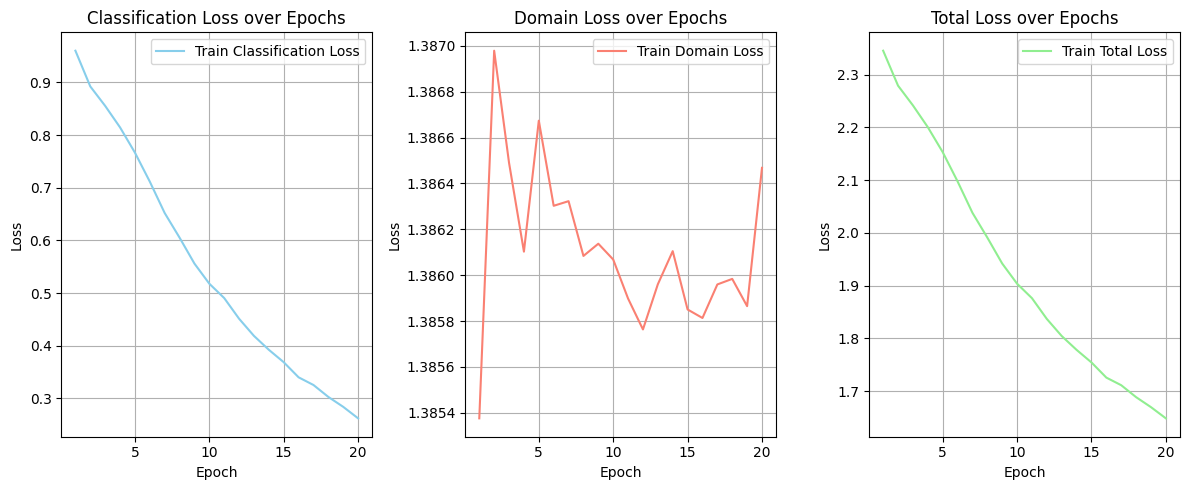

In [173]:
import matplotlib.pyplot as plt

# Extracting training history
train_cls_loss = history["train_cls_loss"]
train_domain_loss = history["train_domain_loss"]
train_total_loss = history["train_total_loss"]
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plotting Classification Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_cls_loss, label="Train Classification Loss", color='skyblue')
plt.title("Classification Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plotting Domain Loss
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_domain_loss, label="Train Domain Loss", color='salmon')
plt.title("Domain Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plotting Total Loss
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_total_loss, label="Train Total Loss", color='lightgreen')
plt.title("Total Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

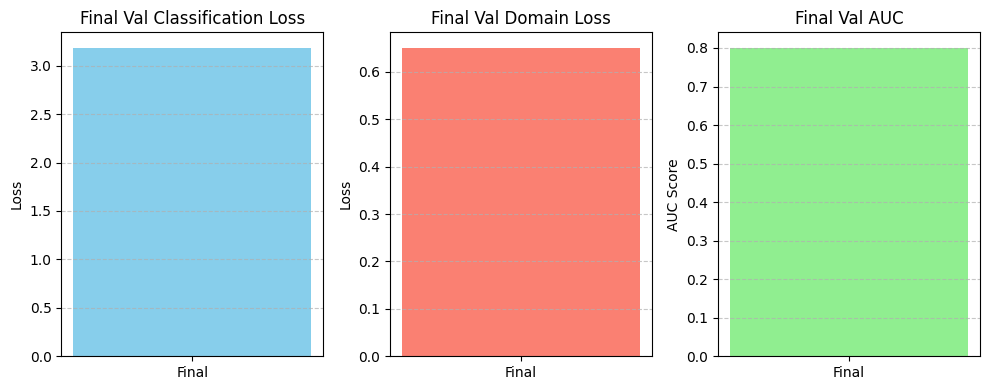

In [174]:
import matplotlib.pyplot as plt

# Extracting validation history
val_cls_loss = validation_history["val_cls_loss"]
val_domain_loss = validation_history["val_domain_loss"]
val_auc = validation_history["val_auc"]

# Since validation was run once after training, these will be single points
# If you integrate validation into the training loop, these will be lists of values

plt.figure(figsize=(10, 4))

# Plotting Validation Classification Loss
plt.subplot(1, 3, 1)
plt.bar(['Final'], [val_cls_loss[0]], color='skyblue')
plt.title("Final Val Classification Loss")
plt.ylabel("Loss")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plotting Validation Domain Loss
plt.subplot(1, 3, 2)
plt.bar(['Final'], [val_domain_loss[0]], color='salmon')
plt.title("Final Val Domain Loss")
plt.ylabel("Loss")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plotting Validation AUC
plt.subplot(1, 3, 3)
plt.bar(['Final'], [val_auc[0]], color='lightgreen')
plt.title("Final Val AUC")
plt.ylabel("AUC Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Took around almost 5 hours by collab pro A100

In [176]:

model_save_path = "dann_densenet121_model.pth"
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to dann_densenet121_model.pth


In [ ]:
import torch

# Define the path to your saved model
model_save_path = "dann_densenet121_model.pth"

# Create an instance of your model architecture
# Ensure num_diseases is the same as when the model was saved
num_diseases = len(shared_diseases) # This should be 8
inference_model = DANN_DenseNet121(num_diseases=num_diseases).to(device)

# Load the saved state dictionary
inference_model.load_state_dict(torch.load(model_save_path, map_location=device))

# Set the model to evaluation mode
inference_model.eval()

print("Model loaded successfully for inference!")